In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from itertools import chain
from pathlib import Path
import numpy as np

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

data_file = Path('Data') / 'Global_Cybersecurity_Threats_2015-2024.csv'
df = pd.read_csv(data_file)

# Number of Attacks by Year and Attack Type

/tmp/ipykernel_44812/2827286128.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



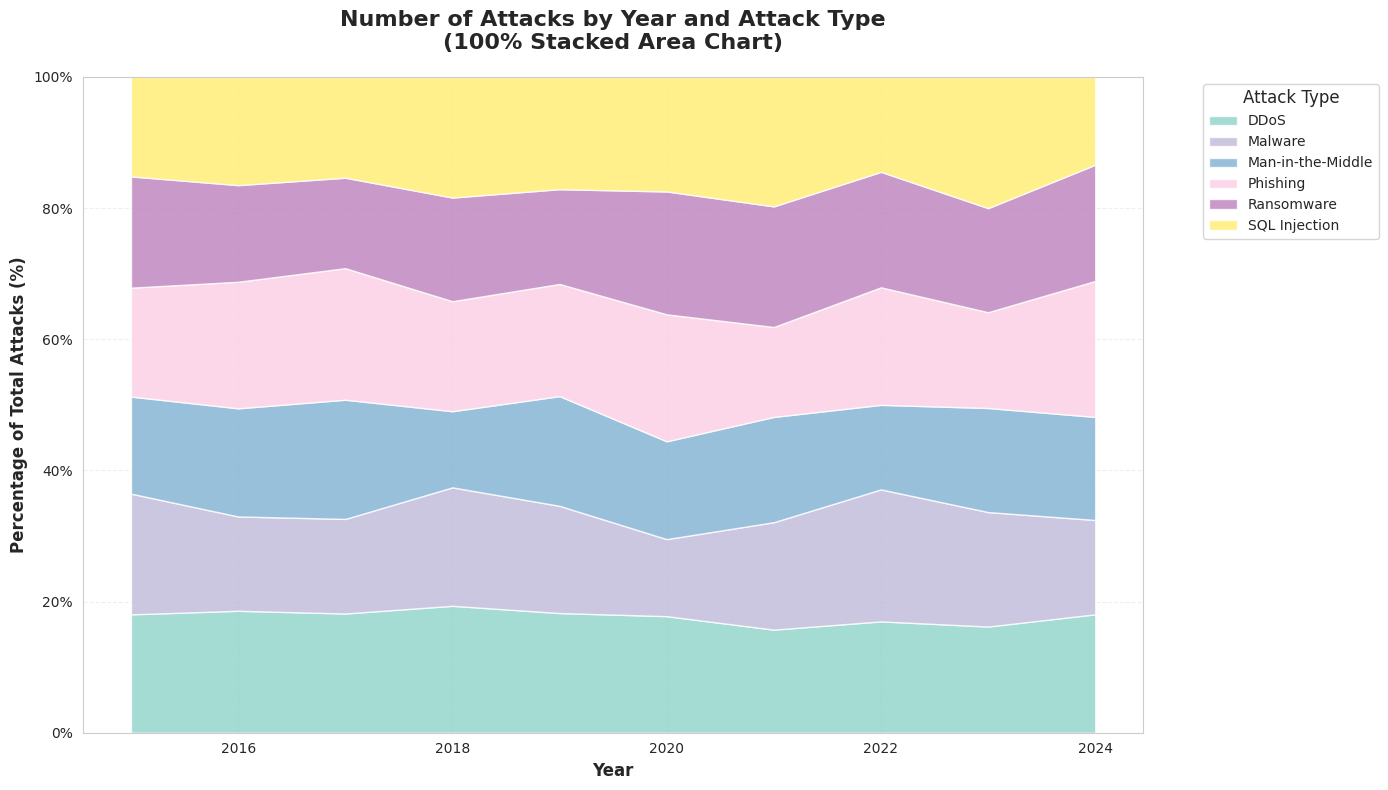

In [7]:
def create_stacked_area_chart(df):
    attack_counts = df.groupby(['Year', 'Attack Type']).size().reset_index(name='Count')
    
    pivot_data = attack_counts.pivot(index='Year', columns='Attack Type', values='Count')
    
    pivot_data = pivot_data.fillna(0)
    
    pivot_percentages = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
    
    plt.figure(figsize=(14, 8))
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(pivot_percentages.columns)))
    
    plt.stackplot(pivot_percentages.index, 
                  *[pivot_percentages[col] for col in pivot_percentages.columns],
                  labels=pivot_percentages.columns,
                  colors=colors,
                  alpha=0.8)
    
    plt.title('Number of Attacks by Year and Attack Type\n(100% Stacked Area Chart)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Percentage of Total Attacks (%)', fontsize=12, fontweight='bold')
    
    plt.grid(True, alpha=0.3, linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
               fontsize=10, title='Attack Type', title_fontsize=12)
    
    plt.ylim(0, 100)
    
    plt.gca().set_yticklabels([f'{int(y)}%' for y in plt.gca().get_yticks()])
    
    plt.tight_layout()
    
    plt.show()

create_stacked_area_chart(df)

# Number of Attacks by Target Industry (colored by average financial loss)

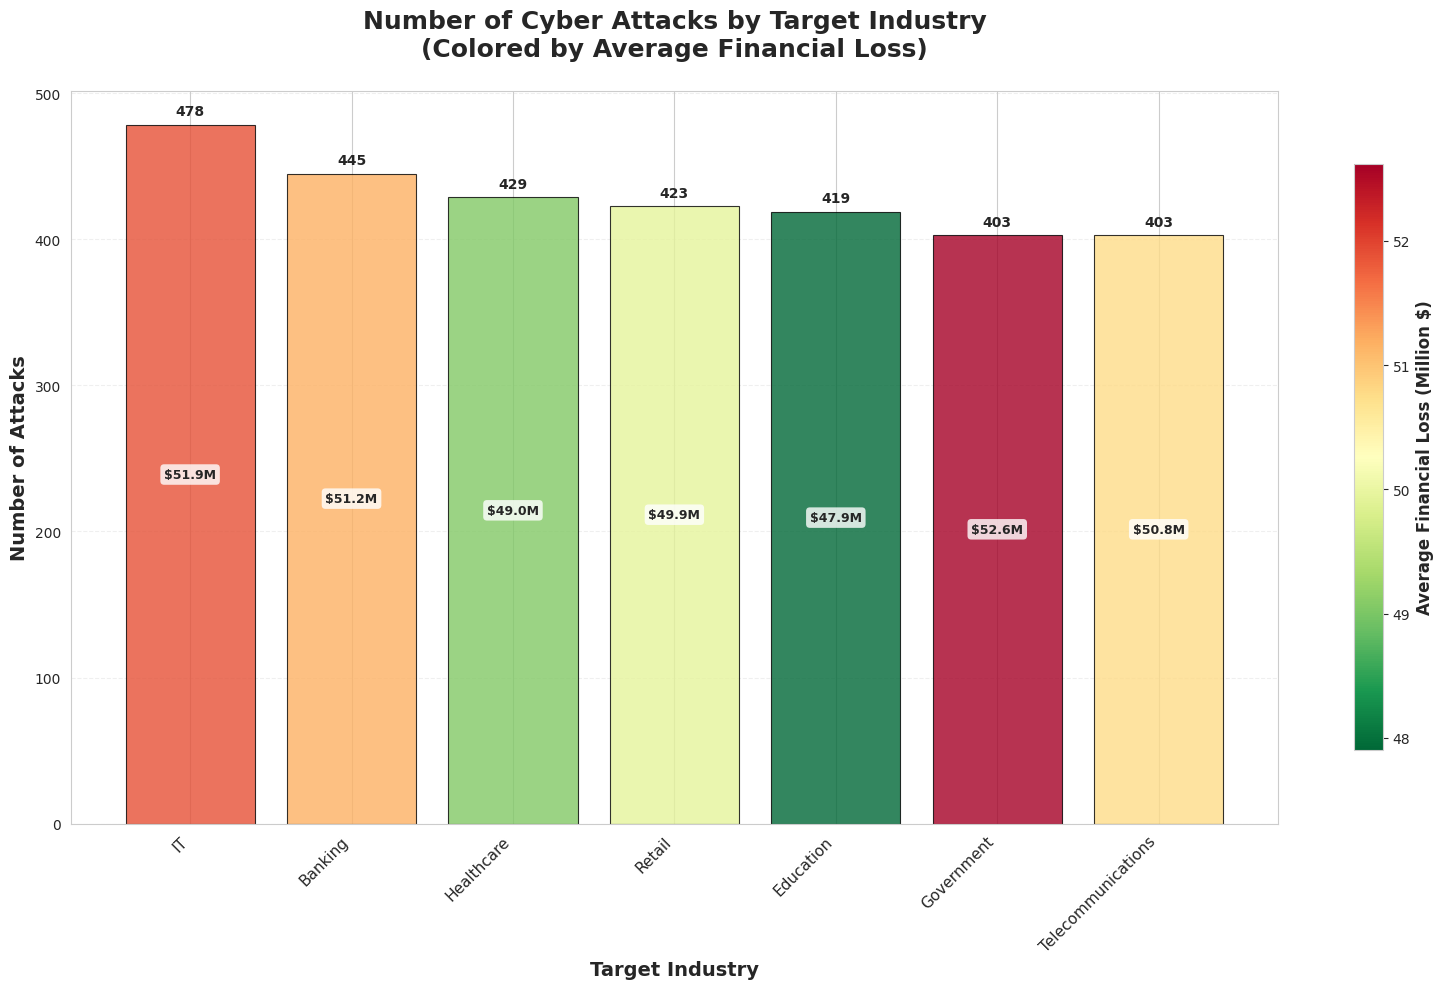

In [10]:
def create_clustered_column_chart(df):
    industry_stats = df.groupby('Target Industry').agg({
        'Financial Loss (in Million $)': ['count', 'mean'],
        'Number of Affected Users': 'mean'
    }).round(2)
    
    industry_stats.columns = ['Attack_Count', 'Avg_Financial_Loss', 'Avg_Affected_Users']
    industry_stats = industry_stats.reset_index()
    
    industry_stats = industry_stats.sort_values('Attack_Count', ascending=False)
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    norm_financial_loss = (industry_stats['Avg_Financial_Loss'] - industry_stats['Avg_Financial_Loss'].min()) / \
                         (industry_stats['Avg_Financial_Loss'].max() - industry_stats['Avg_Financial_Loss'].min())
    
    colors = cm.RdYlGn_r(norm_financial_loss)  # _r for reversed (red=high, green=low)
    
    bars = ax.bar(range(len(industry_stats)), 
                  industry_stats['Attack_Count'],
                  color=colors,
                  alpha=0.8,
                  edgecolor='black',
                  linewidth=0.8)
    
    ax.set_title('Number of Cyber Attacks by Target Industry\n(Colored by Average Financial Loss)', 
                 fontsize=18, fontweight='bold', pad=25)
    ax.set_xlabel('Target Industry', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Attacks', fontsize=14, fontweight='bold')
    
    ax.set_xticks(range(len(industry_stats)))
    ax.set_xticklabels(industry_stats['Target Industry'], rotation=45, ha='right', fontsize=11)
    
    for i, (bar, count, avg_loss) in enumerate(zip(bars, industry_stats['Attack_Count'], industry_stats['Avg_Financial_Loss'])):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(count)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                f'${avg_loss:.1f}M',
                ha='center', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))
    
    sm = plt.cm.ScalarMappable(cmap=cm.RdYlGn_r, 
                               norm=plt.Normalize(vmin=industry_stats['Avg_Financial_Loss'].min(), 
                                                vmax=industry_stats['Avg_Financial_Loss'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=20)
    cbar.set_label('Average Financial Loss (Million $)', fontsize=12, fontweight='bold')
    
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()

create_clustered_column_chart(df)

# Number of Attacks by Attack Source and Vulnerability Type

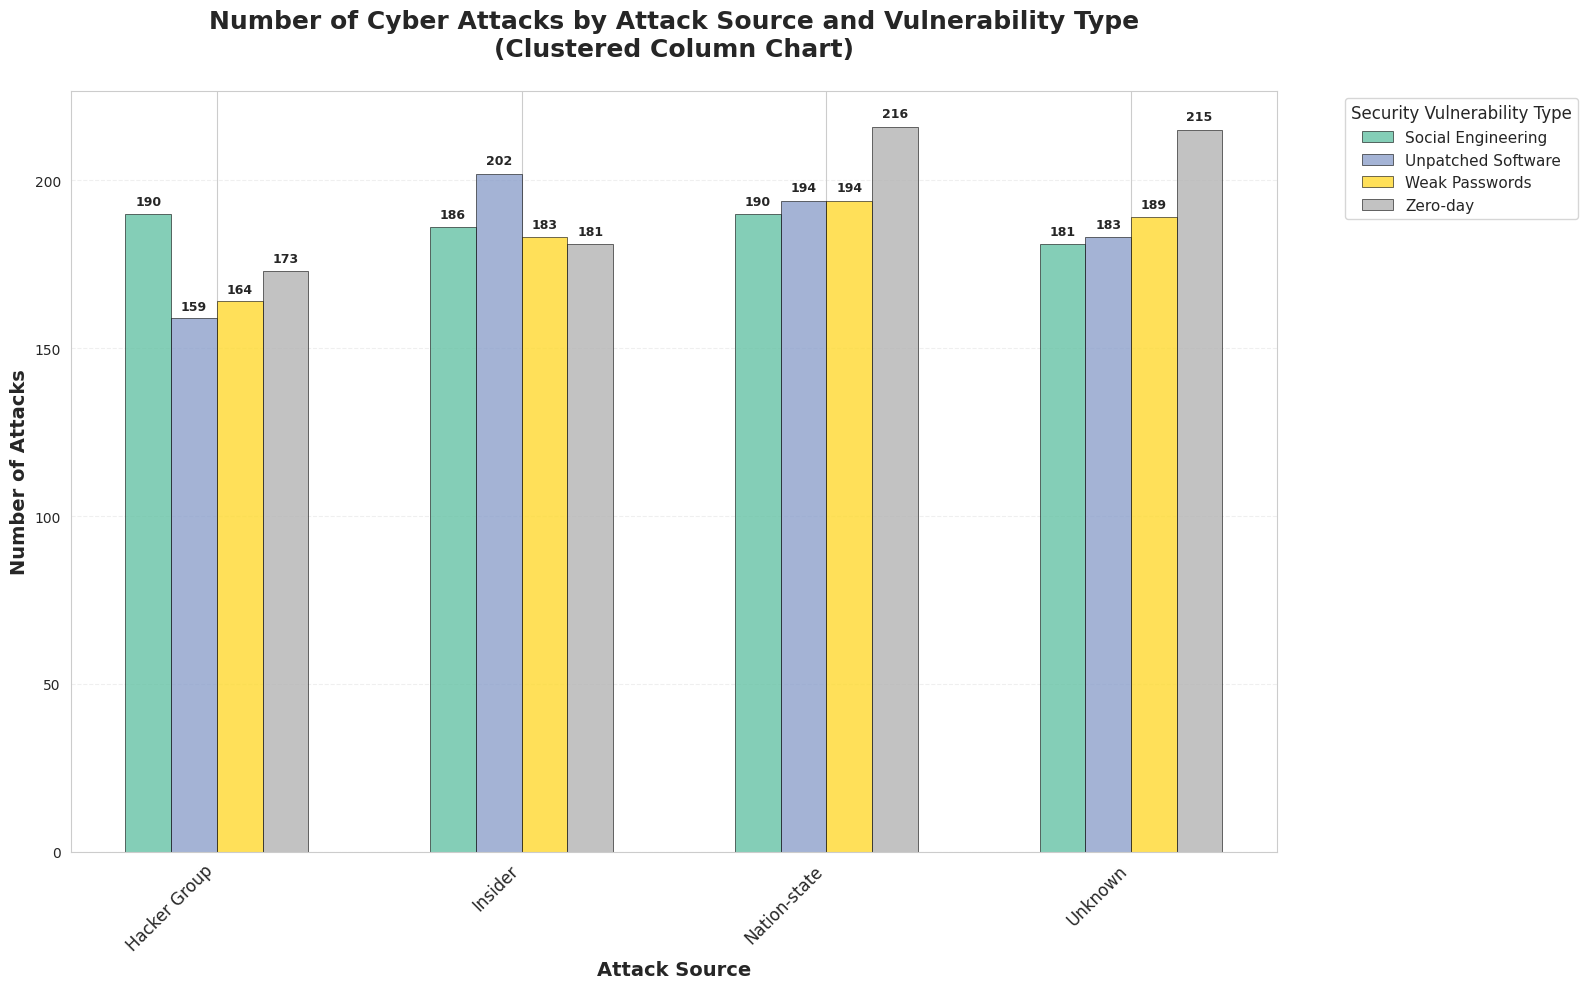

In [12]:
def create_attack_source_vulnerability_chart(df):
    source_vuln_counts = df.groupby(['Attack Source', 'Security Vulnerability Type']).size().reset_index(name='Count')
    
    pivot_data = source_vuln_counts.pivot(index='Attack Source', 
                                         columns='Security Vulnerability Type', 
                                         values='Count').fillna(0)
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    bar_width = 0.15
    n_vuln_types = len(pivot_data.columns)
    n_sources = len(pivot_data.index)
    
    r = np.arange(n_sources)
    positions = [r + i * bar_width for i in range(n_vuln_types)]
    
    colors = plt.cm.Set2(np.linspace(0, 1, n_vuln_types))
    
    bars = []
    for i, (vuln_type, color) in enumerate(zip(pivot_data.columns, colors)):
        bars.append(ax.bar(positions[i], pivot_data[vuln_type], 
                          bar_width, label=vuln_type, color=color, 
                          alpha=0.8, edgecolor='black', linewidth=0.5))
    
    ax.set_title('Number of Cyber Attacks by Attack Source and Vulnerability Type\n(Clustered Column Chart)', 
                 fontsize=18, fontweight='bold', pad=25)
    ax.set_xlabel('Attack Source', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Attacks', fontsize=14, fontweight='bold')
    
    ax.set_xticks(r + bar_width * (n_vuln_types - 1) / 2)
    ax.set_xticklabels(pivot_data.index, rotation=45, ha='right', fontsize=12)
    
    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            if height > 0:  # Only label non-zero bars
                ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.legend(title='Security Vulnerability Type', 
              bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=11, title_fontsize=12)
    
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()

create_attack_source_vulnerability_chart(df)

# Number of Attacks by Attack Type and Country

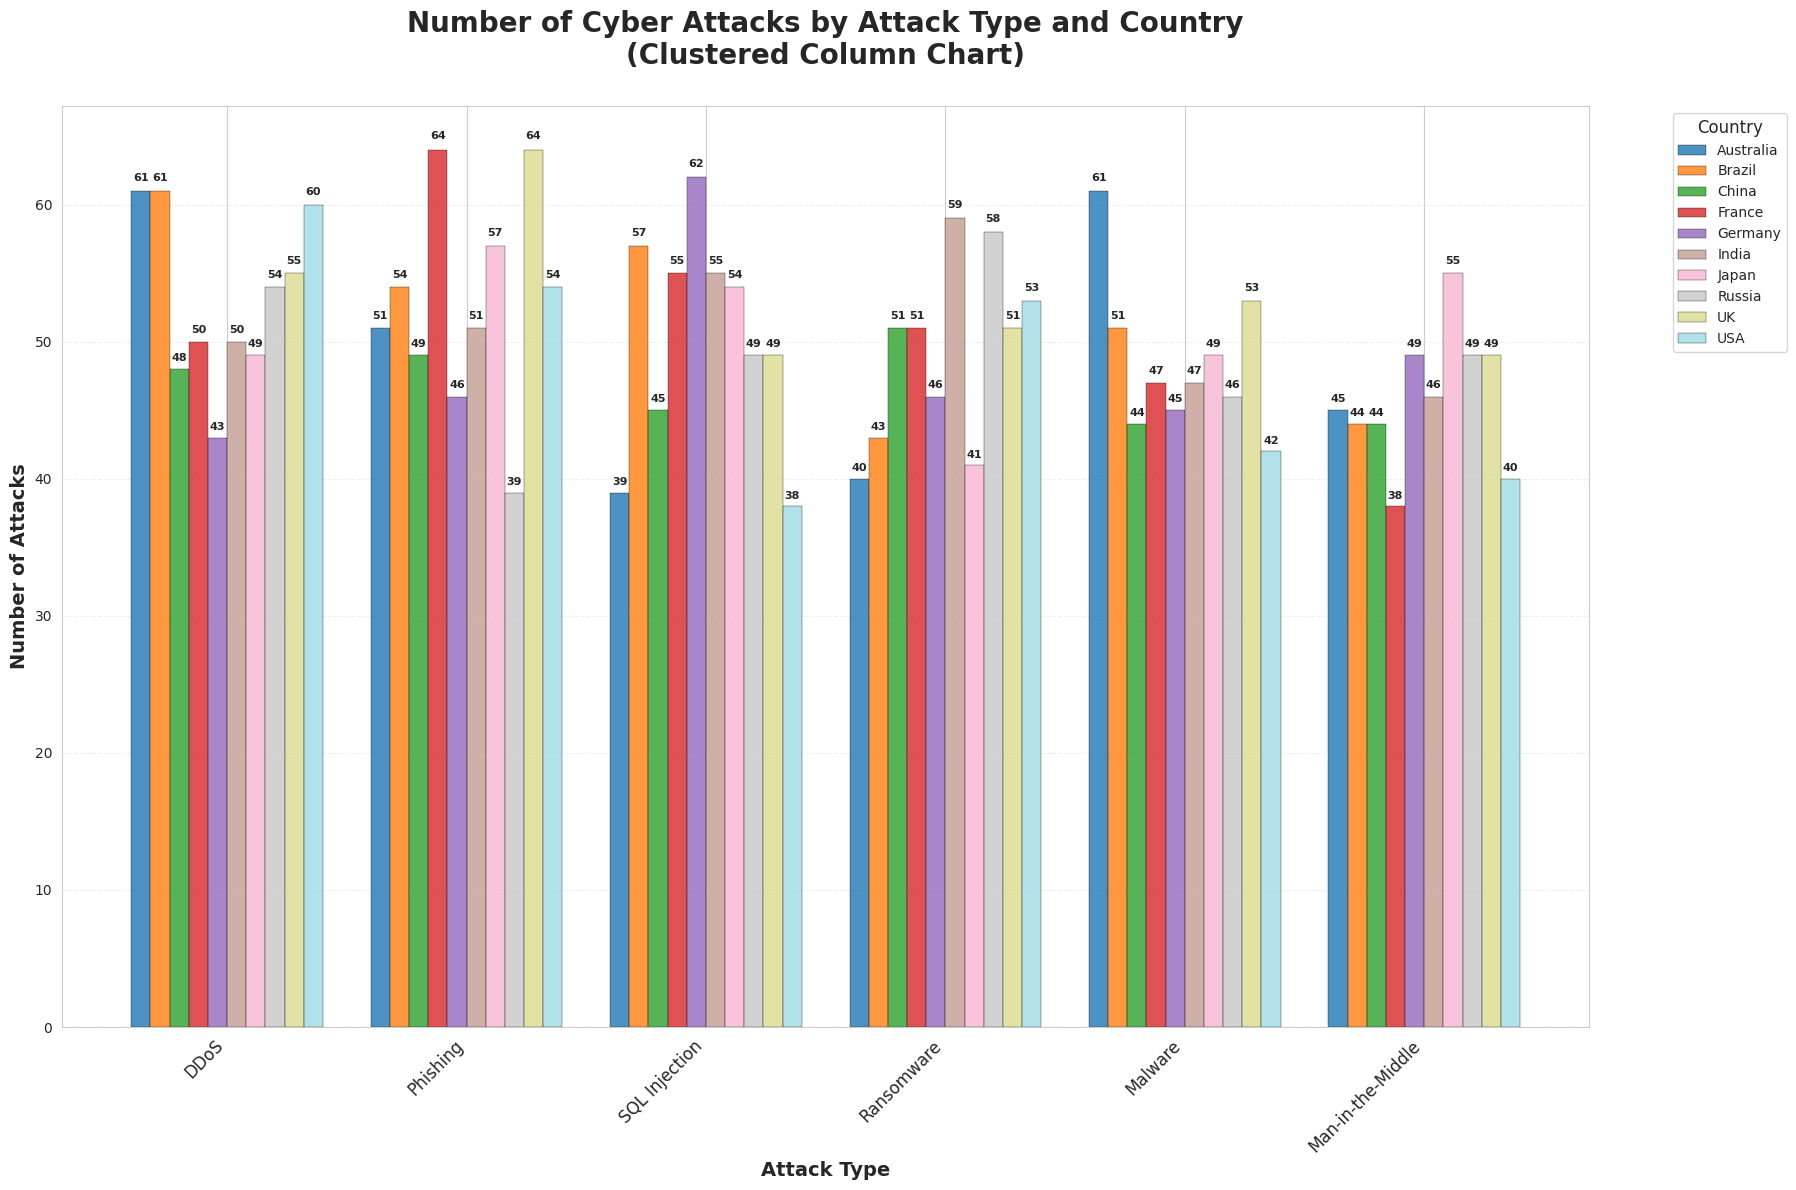

In [13]:
def create_attack_type_country_chart(df):
    type_country_counts = df.groupby(['Attack Type', 'Country']).size().reset_index(name='Count')
    
    pivot_data = type_country_counts.pivot(index='Attack Type', 
                                          columns='Country', 
                                          values='Count').fillna(0)
    
    attack_totals = pivot_data.sum(axis=1).sort_values(ascending=False)
    pivot_data = pivot_data.reindex(attack_totals.index)
    
    fig, ax = plt.subplots(figsize=(18, 12))
    
    bar_width = 0.08
    n_countries = len(pivot_data.columns)
    n_attack_types = len(pivot_data.index)
    
    r = np.arange(n_attack_types)
    positions = [r + i * bar_width for i in range(n_countries)]
    
    colors = plt.cm.tab20(np.linspace(0, 1, n_countries))
    
    bars = []
    for i, (country, color) in enumerate(zip(pivot_data.columns, colors)):
        bars.append(ax.bar(positions[i], pivot_data[country], 
                          bar_width, label=country, color=color, 
                          alpha=0.8, edgecolor='black', linewidth=0.3))
    
    ax.set_title('Number of Cyber Attacks by Attack Type and Country\n(Clustered Column Chart)', 
                 fontsize=20, fontweight='bold', pad=30)
    ax.set_xlabel('Attack Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Attacks', fontsize=14, fontweight='bold')
    
    ax.set_xticks(r + bar_width * (n_countries - 1) / 2)
    ax.set_xticklabels(pivot_data.index, rotation=45, ha='right', fontsize=12)
    
    threshold = pivot_data.values.max() * 0.05  
    for bar_group in bars:
        for bar in bar_group:
            height = bar.get_height()
            if height > threshold:
                ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    n_cols = min(4, (n_countries + 3) // 4)  
    ax.legend(title='Country', 
              bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=10, title_fontsize=12, ncol=max(1, n_countries // 8))
    
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()

create_attack_type_country_chart(df)

# Number of Attacks by Industry and Country

<Figure size 1400x700 with 0 Axes>

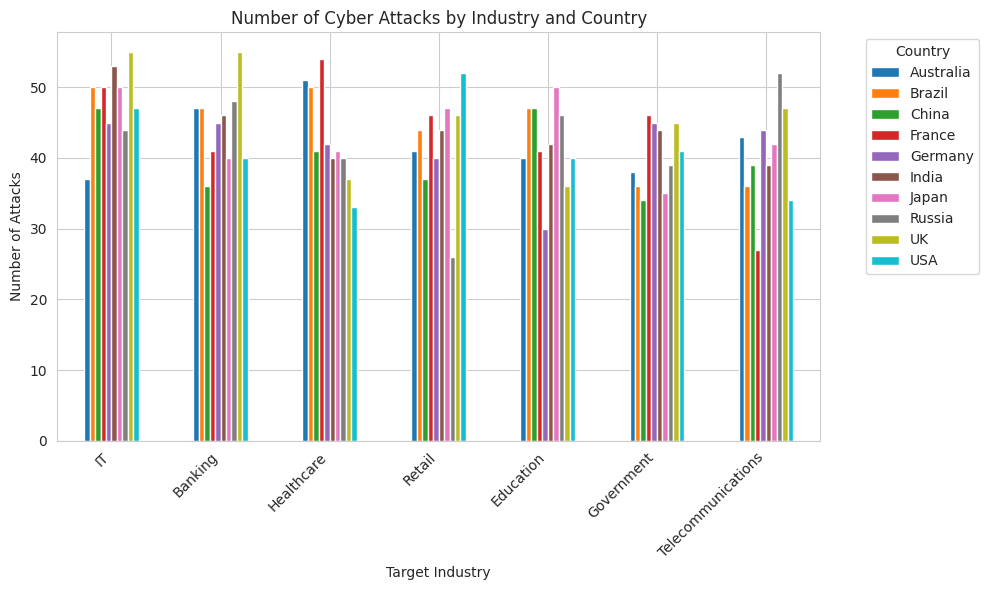

In [ ]:
def create_clustered_attacks_by_industry_country(df):
    pivot = df.pivot_table(
        index='Target Industry',
        columns='Country',
        values='Year',
        aggfunc='count',
        fill_value=0
    )

    pivot['Total'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('Total', ascending=False).drop(columns='Total')

    plt.figure(figsize=(14, 7))
    ax = pivot.plot(kind='bar')
    ax.set_ylabel('Number of Attacks')
    ax.set_title('Number of Cyber Attacks by Industry and Country')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

create_clustered_attacks_by_industry_country(df)

# Number of Attacks by Industry and Country

<Figure size 1400x700 with 0 Axes>

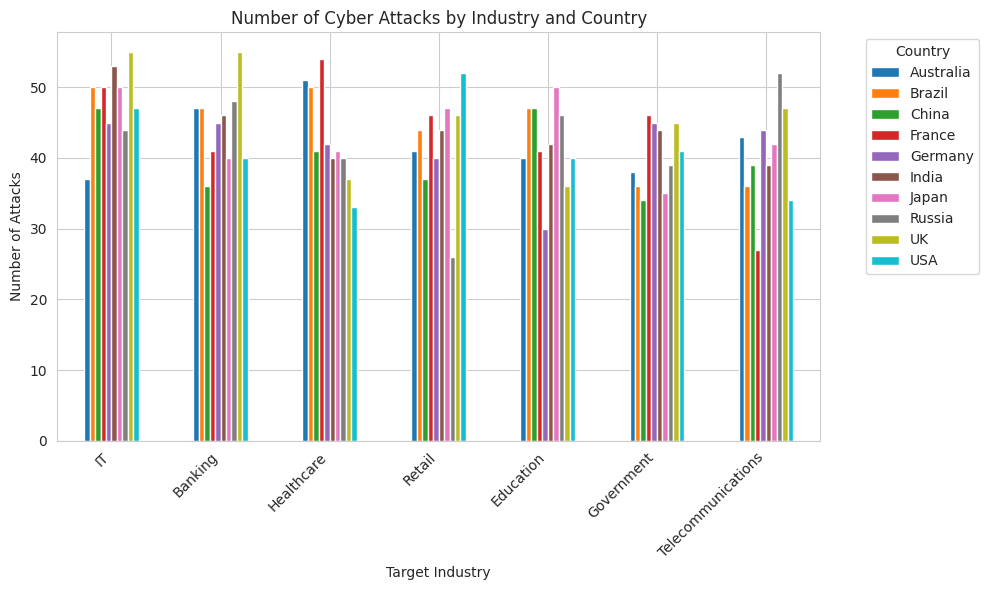

In [16]:
def create_clustered_attacks_by_industry_country(df):
    pivot = df.pivot_table(
        index='Target Industry',
        columns='Country',
        values='Year',
        aggfunc='count',
        fill_value=0
    )
    pivot['Total'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('Total', ascending=False).drop(columns='Total')

    plt.figure(figsize=(14, 7))
    ax = pivot.plot(kind='bar')
    ax.set_ylabel('Number of Attacks')
    ax.set_title('Number of Cyber Attacks by Industry and Country')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

create_clustered_attacks_by_industry_country(df)

# Number of Attacks by Attack Type and Industry

<Figure size 1600x800 with 0 Axes>

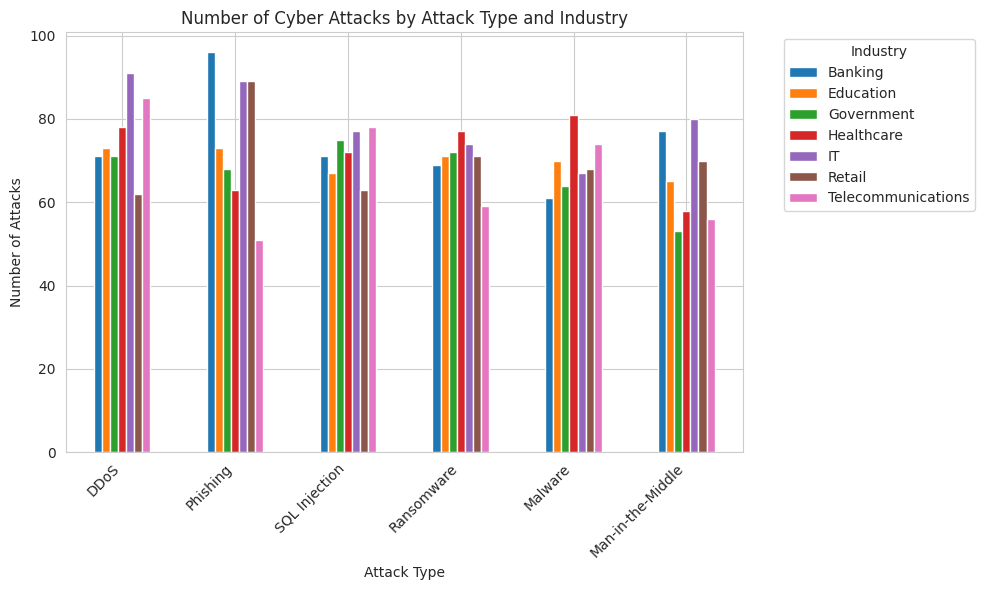

In [17]:
def create_clustered_attacks_by_attacktype_industry(df):
    pivot = df.pivot_table(
        index='Attack Type',
        columns='Target Industry',
        values='Year',
        aggfunc='count',
        fill_value=0
    )

    pivot['Total'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('Total', ascending=False).drop(columns='Total')

    plt.figure(figsize=(16, 8))
    ax = pivot.plot(kind='bar')
    ax.set_ylabel('Number of Attacks')
    ax.set_title('Number of Cyber Attacks by Attack Type and Industry')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

create_clustered_attacks_by_attacktype_industry(df)

# Number of Attacks by Attack Type and Country

<Figure size 1600x800 with 0 Axes>

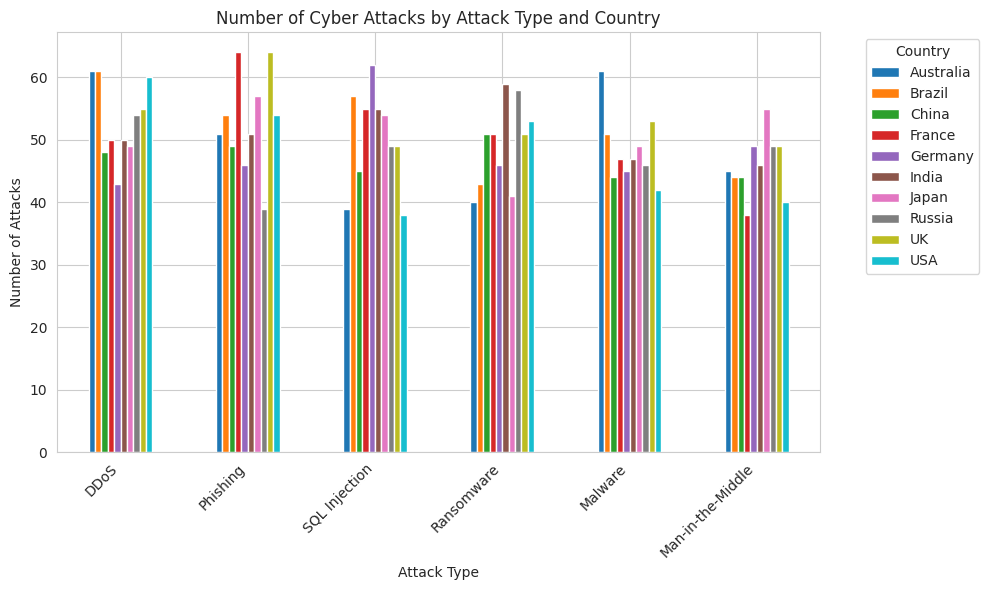

In [18]:
def create_clustered_attacks_by_attacktype_country(df):
    pivot = df.pivot_table(
        index='Attack Type',
        columns='Country',
        values='Year',
        aggfunc='count',
        fill_value=0
    )

    pivot['Total'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('Total', ascending=False).drop(columns='Total')

    plt.figure(figsize=(16, 8))
    ax = pivot.plot(kind='bar')
    ax.set_ylabel('Number of Attacks')
    ax.set_title('Number of Cyber Attacks by Attack Type and Country')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

create_clustered_attacks_by_attacktype_country(df)

# Total Affected Users by Target Industry (colored by sum of financial loss)

/tmp/ipykernel_44812/1686197588.py:16: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



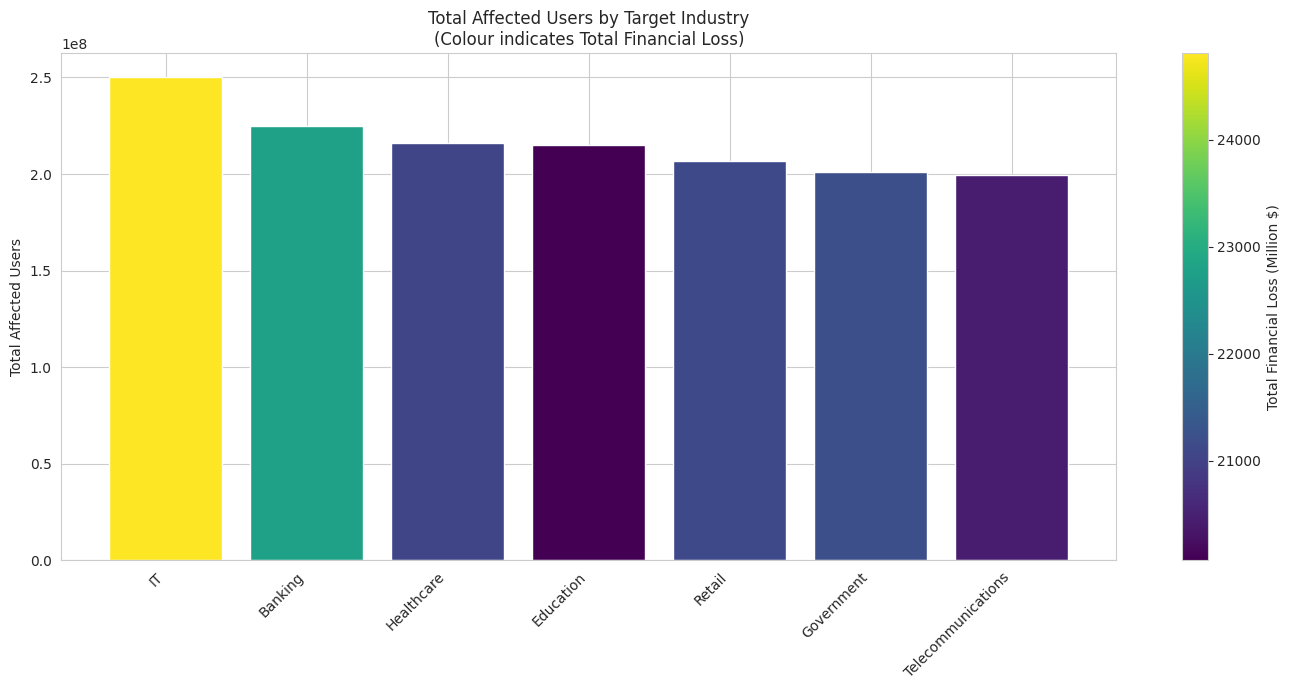

In [ ]:
def create_total_affected_users_by_industry_colored_loss(df):
    agg = df.groupby('Target Industry').agg(
        Total_Affected_Users=('Number of Affected Users', 'sum'),
        Total_Financial_Loss=('Financial Loss (in Million $)', 'sum')
    ).sort_values('Total_Affected_Users', ascending=False)

    loss_values = agg['Total_Financial_Loss'].values
    norm = (loss_values - loss_values.min()) / (loss_values.max() - loss_values.min() + 1e-9)
    cmap = plt.get_cmap("viridis")
    colours = cmap(norm)

    fig, ax = plt.subplots(figsize=(14, 7))
    bars = ax.bar(agg.index, agg['Total_Affected_Users'], color=colours)
    ax.set_ylabel('Total Affected Users')
    ax.set_title('Total Affected Users by Target Industry\n(Color indicates Total Financial Loss)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=loss_values.min(), vmax=loss_values.max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Total Financial Loss (Million $)')

    fig.tight_layout()
    plt.show()

create_total_affected_users_by_industry_colored_loss(df)

# Incident Resolution Time by Year and Attack Type

<Figure size 1400x700 with 0 Axes>

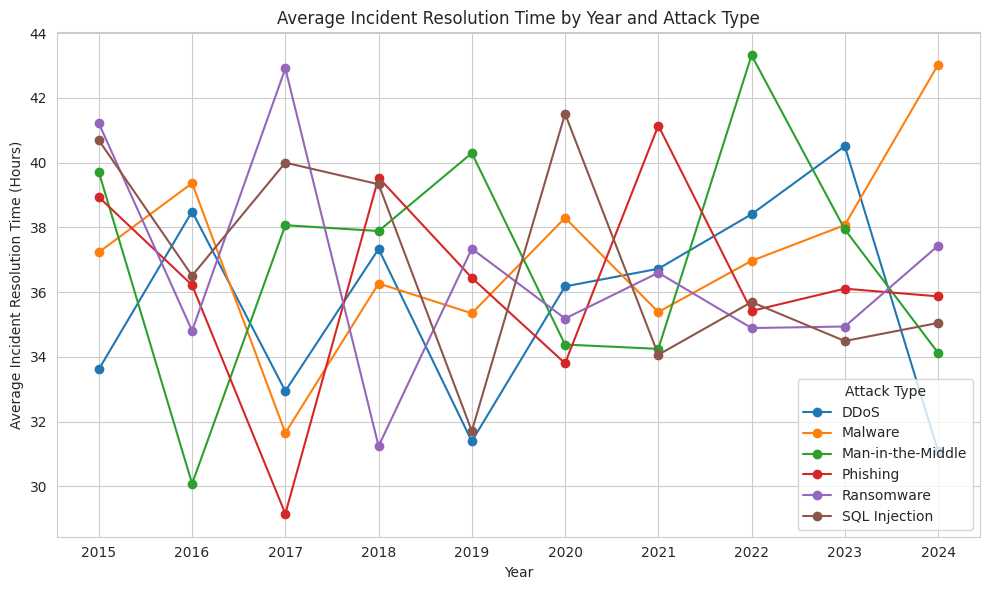

In [23]:
def create_incident_res_time_by_year_attacktype_line(df):
    pivot = (
        df.groupby(['Year', 'Attack Type'])['Incident Resolution Time (in Hours)']
          .mean()
          .unstack('Attack Type')
          .sort_index()
    )

    plt.figure(figsize=(14, 7))
    ax = pivot.plot(marker='o')
    ax.set_ylabel('Average Incident Resolution Time (Hours)')
    ax.set_title('Average Incident Resolution Time by Year and Attack Type')
    ax.set_xticks(pivot.index)
    plt.tight_layout()
    plt.show()

create_incident_res_time_by_year_attacktype_line(df)

# Changing share of attack types over time

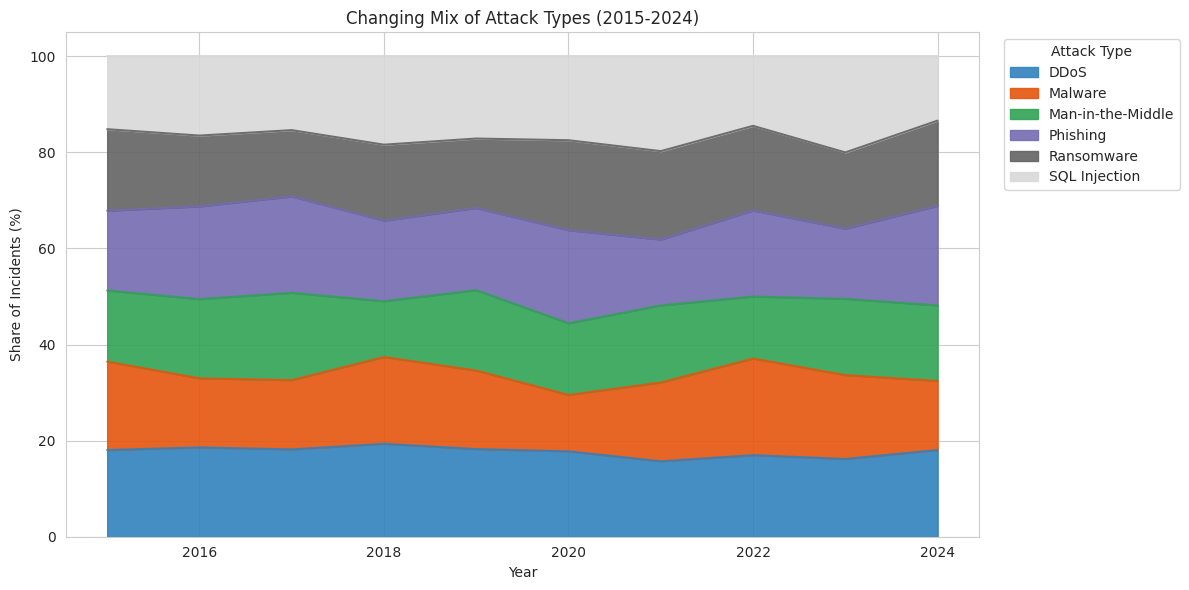

In [3]:
area_df = (
    df.groupby(["Year", "Attack Type"])
      .size()
      .reset_index(name="Incidents")
      .pivot(index="Year", columns="Attack Type", values="Incidents")
      .fillna(0)
)

area_df_pct = area_df.div(area_df.sum(axis=1), axis=0) * 100

area_df_pct.plot.area(
    figsize=(12, 6),
    cmap="tab20c",
    alpha=0.9
)
plt.gca().set_prop_cycle(None)
plt.legend(bbox_to_anchor=(1.02, 1), title="Attack Type")
plt.ylabel("Share of Incidents (%)")
plt.title("Changing Mix of Attack Types (2015-2024)")
plt.tight_layout()
plt.show()


# Pipeline Attack Source → Attack Type → Target Industry with link widths proportional to incident counts

In [4]:
triplets = (
    df.groupby(["Attack Source", "Attack Type", "Target Industry"])
      .size().reset_index(name="Count")
)

sources   = triplets["Attack Source"].unique().tolist()
types_    = triplets["Attack Type"].unique().tolist()
targets   = triplets["Target Industry"].unique().tolist()

nodes = sources + types_ + targets

idx = {label: i for i, label in enumerate(nodes)}

links_src, links_tgt, links_val = [], [], []

for _, row in triplets.iterrows():
    links_src.append(idx[row["Attack Source"]])
    links_tgt.append(idx[row["Attack Type"]])
    links_val.append(row["Count"])

    links_src.append(idx[row["Attack Type"]])
    links_tgt.append(idx[row["Target Industry"]])
    links_val.append(row["Count"])

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=nodes,
        pad=15, thickness=15,
        line=dict(width=0.5, color="black")
    ),
    link=dict(
        source=links_src,
        target=links_tgt,
        value=links_val
    )
)])
fig.update_layout(
    title_text="Attack Source → Attack Type → Target Industry (Count of Incidents)",
    font_size=11,
    height=700
)
fig.show()